## Load libraries and Data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
import json # import json for formatting data
import os # and os for saving
import boto3
import sagemaker
from sagemaker import get_execution_role
import pickle

In [2]:
train_file = 'data/train.csv'
train_df = pd.read_csv(train_file)
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [3]:
# Save as Dataframe the train file and use Date as Index
train_df['Date'] = [datetime.strptime(date, '%Y-%m-%d').date() for date in train_df['Date'].astype(str).values.tolist()]
train_df.index = train_df['Date']
train_df = train_df.drop(['Date'], axis=1)
train_df.sort_values(["Store","Dept"], ascending = (False,False))

train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


## Convert features to use as dynamical features in DeepAR

In [4]:
# Set missing value to 0
train_df.fillna(0, inplace=True)

# Set negative sales to 0
train_df.loc[train_df['Weekly_Sales'] < 0, 'Weekly_Sales'] = 0

# In competition evaluation, weights in WMAE are 5 if week is holiday, 1 otherwise
train_df['IsHoliday'].replace([False,True], [1,5], inplace = True)

train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,1
2010-02-12,1,1,46039.49,5
2010-02-19,1,1,41595.55,1
2010-02-26,1,1,19403.54,1
2010-03-05,1,1,21827.90,1


In [5]:
# Look at the Store list to see if there are missing numbers
print(train_df.Store.unique())
print(train_df.Store.nunique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
45


In [6]:
# Look at the Dept list to see if there are missing numbers
print(train_df.Dept.unique())
print(train_df.Dept.nunique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 44 45 46 47 48 49 51 52
 54 55 56 58 59 60 67 71 72 74 77 78 79 80 81 82 83 85 87 90 91 92 93 94
 95 96 97 98 99 39 50 43 65]
81


In DeepAR, Categorical features must be encoded as a 0-based sequence of positive integers.  
https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html  
We want a list of 45 Stores and another of 81 Departments, each starting by 0

In [7]:
# Add Cat_Store columns to convert Store to a "Category" field appropriate for DeepAR
train_df['Cat_Store'] = train_df['Store'] - 1

# Add Cat_Dept columns to convert Dept to a "Category" field appropriate for DeepAR
liste = range(81)
for i in liste:
    department = train_df.Dept.unique()[i]
    train_df.loc[train_df['Dept'] == department, 'Cat_Dept'] = int(i)  

train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Cat_Store,Cat_Dept
Date,,,,,,
2010-02-05,1,1,24924.50,1,0,0.0
2010-02-12,1,1,46039.49,5,0,0.0
2010-02-19,1,1,41595.55,1,0,0.0
2010-02-26,1,1,19403.54,1,0,0.0
2010-03-05,1,1,21827.90,1,0,0.0


In [8]:
# Verify Cat_Store
print(train_df.Cat_Store.unique())
print(train_df.Cat_Store.nunique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
45


In [9]:
# Verify Cat_Dept
print(train_df.Cat_Dept.unique())
print(train_df.Cat_Dept.nunique())

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80.]
81


In [10]:
# take only 2 stores to stay within AWS Sagemaker size limit when using the deployed model to predict
train_df = train_df[train_df.Store < 3]
train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Cat_Store,Cat_Dept
Date,,,,,,
2010-02-05,1,1,24924.50,1,0,0.0
2010-02-12,1,1,46039.49,5,0,0.0
2010-02-19,1,1,41595.55,1,0,0.0
2010-02-26,1,1,19403.54,1,0,0.0
2010-03-05,1,1,21827.90,1,0,0.0


## Plot Sales Evolution

In [11]:
# Define a function to plot sales evolution depending of the store and department number
def sales_evolution(store_number, dept_number):
    example_store_dept_sales = train_df[(train_df.Store == store_number) & (train_df.Dept == dept_number)]['Weekly_Sales']
    plt.figure(figsize=(8,3))
    example_store_dept_sales.plot(title='Store {} Dpt {} Sales evolution'.format(store_number, dept_number), color='blue') 
    return plt.show()

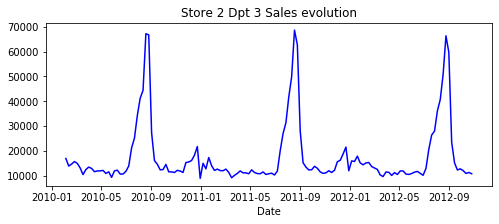

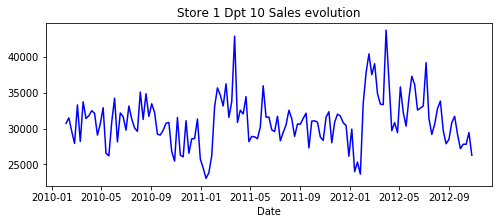

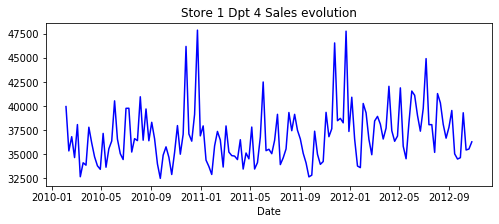

In [12]:
# Plot some examples
sales_evolution(2,3)
sales_evolution(1,10)
sales_evolution(1,4)

## Create and display complete time series and dynamic features

In [13]:
def make_time_series(df, freq='W-FRI'):
    '''Creates as many time series as they are stores x departments
      :param df: dataframe with train data. One 3 columns : Store, Dept, Weekly_Sales.
          This dataframe should also be indexed by a datetime.
      :param freq: The frequency of data recording (W-FRI = Weekly, starting on Friday)
      :return: A list of pd.Series(), time series data.
      '''
    
    # store time series
    time_series = []
    
    # create time series for each store and each department
    for store in df.Cat_Store.unique().tolist():
        for dept in df.Cat_Dept.unique().tolist():
            
            # create DataFrame with weekly_sales for the store and department studied
            sample_df = df[(df.Cat_Store == store) & (df.Cat_Dept == dept)]['Weekly_Sales']   
            
            # initialise start_idx
            start_idx = 0
            end_idx = start_idx+143

            # create start and datetime
            t_start = '2010-02-05' # start with first date 

            # get wanted sample_df data
            data = sample_df[start_idx:end_idx]

            # create time series
            index = pd.date_range(start=t_start, periods=143, freq=freq)
            Serie_df = pd.Series(data=data, index=index)

            # include info of the store and dept as last values to use as category in DeepAR
            Info_df = pd.Series(data=[int(store), int(dept)], index=['store','dept'])
            time_series.append(pd.concat([Serie_df, Info_df]))               
    
    # return list of time series
    return time_series

In [14]:
# Create time series for all store and departments
freq='W-FRI' # weekly recordings

# make time series
time_series = make_time_series(train_df, freq=freq)

In [15]:
def make_dyn_feat(df, features, prediction_length, freq='W-FRI'):
    '''Create dynamic_features for each stores, each years and each selected features
      :param df: dataframe with train data. Contain at least the selected features in columns and Store number
          This dataframe should also be indexed by a datetime.
      :param features : list of choosen dynamical features, evolving over time
      :param prediction_length : length of dyn_features = 52 - prediction_length (usefull for training series)
      :param freq: The frequency of data recording (W-FRI = Weekly, starting on Friday)
      :return: A 3 dimensional list : Store / year / features
      '''

    # instantiate dynamic features list
    dynamic_feat = []
    
    # create dynamic feature for each store 
    for store in df.Cat_Store.unique().tolist():
        
        # instantite store list
        store_feat=[]
        
        # select features columns and filter on store number.
        # choose one Dept to have only one line for each date
        # Dynamic features are linked to the store, not the departments
        dyn_df = df.loc[(df.Cat_Store == store) & (df.Cat_Dept == 1), features]
        
        # initialise start_idx
        start_idx = 0
        # we get 144 weeks in our dataset, starting at index 0
        end_idx = start_idx + 143 - prediction_length

        # get wanted sample_df data
        dyn_temp_df = dyn_df[start_idx:end_idx]

        for j in features:
            store_feat.append(dyn_temp_df[j].tolist())
            #store_feat = dyn_temp_df[j].tolist()
            
        if df['Cat_Store'].nunique() > 1:
            dynamic_feat.append(store_feat)
        else:
            dynamic_feat = store_feat
    return dynamic_feat

In [16]:
# Create dynamic features for all data
freq='W-FRI' # weekly recordings
features = ['IsHoliday']
# prediction length for test set
prediction_test = 0

# make dynamic features test series
test_dynamic_features = make_dyn_feat(train_df, features,prediction_test, freq=freq)

#print(test_dynamic_features)

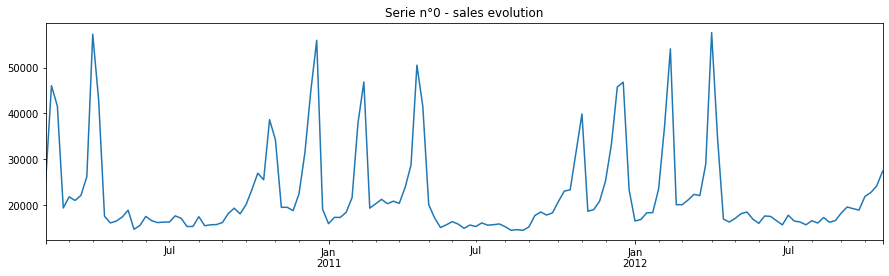

In [17]:
# display first time series
time_series_idx = 0

# plot time series except the last two values corresponding to store and department
plt.figure(figsize=(15,4))
time_series[time_series_idx][:-2].plot(title='Serie n°{} - sales evolution'.format(time_series_idx))
plt.show()

## Splitting in Time

In [18]:
# create truncated, training time series
def create_training_series(complete_time_series, prediction_length):
    '''Given a complete list of time series data, create training time series.
       :param complete_time_series: A list of all complete time series.
       :param prediction_length: The number of points we want to predict.
       :return: A list of training time series.
       '''
    # get training series
    time_series_training = []
    
    for ts in complete_time_series:
        
        # save store and departement number for the serie as Info
        Info_df = ts[-2:]
        
        # truncate "prediction_length" weeks + 2 corresponding to the store and departement number
        truncate = prediction_length + 2
        Train_Serie_df = ts[:-truncate]
        
        # save Train_Serie with its Info
        time_series_training.append(pd.concat([Train_Serie_df, Info_df]))
        
    return time_series_training

In [19]:
# set prediction length to 36 weeks ~ 9 months that we will have to forecast with the trained model
prediction_length = 36 
time_series_training = create_training_series(time_series, prediction_length)

In [20]:
# make dynamic features for train series
train_dynamic_features = make_dyn_feat(train_df, features, prediction_length, freq=freq)

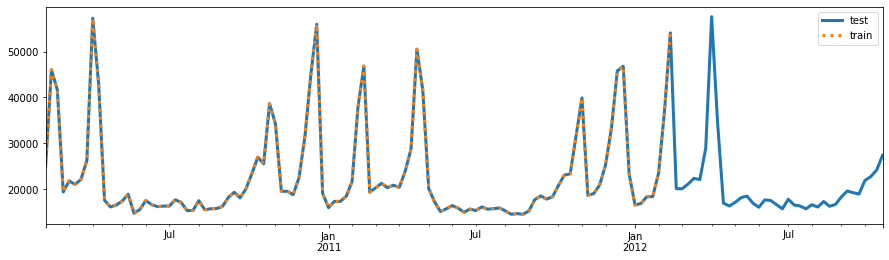

In [21]:
# display train/test time series
time_series_idx = 0

plt.figure(figsize=(15,4))
# test data is the whole time series
time_series[time_series_idx][:-2].plot(label='test', lw=3)
# train data is all but the last prediction pts
time_series_training[time_series_idx][:-2].plot(label='train', ls=':', lw=3)

plt.legend()
plt.show()

## Convert to JSON

In [22]:
def series_to_json_obj(ts, dynamic_features):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :param dynamic_features : dynamical featres corresponding to ts
       :return: A dictionary of values with "start", "target", "cat" and "dynamic_feat" keys.
       '''
    # get start time and target and cat from the time series, ts
    # with 2 lasts values being store and department number, if len(ts)<3, the list is empty
    if len(ts)< 3:
        target = []
    else:
        target = list(ts[:-2])
    no_nan_target = pd.Series(target).fillna('NaN').tolist()
    
    # get dynamic_feat related to the store (same dynamic_feat for all department of one store)
    store = int(ts[-2])
    
    json_obj = {"start": str(ts.index[0]),
                "target": no_nan_target,
                "cat": list(map(int, ts[-2:])),
                "dynamic_feat": dynamic_features[store]
               }
    return json_obj

In [23]:
# test out the code
ts = time_series_training[100]

json_obj = series_to_json_obj(ts,train_dynamic_features)

print(json_obj)

{'start': '2010-02-05 00:00:00', 'target': [9731.05, 11838.72, 9620.64, 8785.76, 8678.56, 7650.12, 6416.62, 5995.61, 8839.61, 8731.12, 7025.53, 6527.13, 5279.71, 6856.03, 5971.1, 7352.65, 7605.71, 7865.05, 6938.34, 6542.43, 6341.13, 7864.03, 5930.88, 5785.82, 7873.69, 10894.4, 15464.74, 14371.26, 24084.77, 19731.92, 6059.35, 5180.93, 4892.42, 4884.66, 7490.25, 8597.51, 6924.63, 5685.51, 7699.94, 10758.45, 9882.2, 9555.0, 18633.55, 13103.91, 24949.2, 18880.73, 18032.75, 3824.32, 5832.43, 5901.66, 5521.55, 5425.96, 8343.52, 9763.95, 7927.01, 6366.97, 7311.89, 6599.46, 6543.77, 6116.47, 6230.74, 5621.35, 6145.48, 7159.79, 5623.76, 4563.31, 5268.62, 5166.66, 5831.95, 6584.94, 8384.43, 6689.47, 5908.7, 5482.89, 6364.86, 5985.18, 6791.2, 7592.65, 11799.02, 14356.6, 24585.84, 18995.15, 5215.29, 4326.63, 4790.21, 4792.96, 4662.72, 5764.43, 5332.8, 8525.54, 7251.87, 9947.73, 8135.39, 6915.09, 14529.15, 10526.0, 26097.66, 14642.07, 17986.73, 5483.91, 4236.56, 3750.01, 4193.36, 4313.9, 6176.76, 8

## Saving Data, Locally

In [24]:
def write_json_dataset(time_series, dynamic_features, filename): 
    with open(filename, 'wb') as f:
        # for each of our times series, there is one JSON line
        for ts in time_series:
            json_line = json.dumps(series_to_json_obj(ts,dynamic_features)) + '\n'
            json_line = json_line.encode('utf-8')
            f.write(json_line)
    print(filename + ' saved.')

In [25]:
# save this data to a local directory
data_dir = 'json_sales_data_dyn'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [26]:
# directories to save train/test data
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

# write train/test JSON files
write_json_dataset(time_series_training, train_dynamic_features, train_key)        
write_json_dataset(time_series, test_dynamic_features, test_key)

json_sales_data_dyn/train.json saved.
json_sales_data_dyn/test.json saved.


## Uploading data to S3

In [27]:
# session, role, bucket
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()

In [28]:
# general prefix
prefix='deepar-weekly-sales'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)

In [29]:
# check locations
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-eu-central-1-293973958717/deepar-weekly-sales/train/train.json
Test data is stored in: s3://sagemaker-eu-central-1-293973958717/deepar-weekly-sales/test/test.json


# Training a DeepAR Estimator

## Instantiate an Estimator

In [30]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image

In [31]:
from sagemaker.estimator import Estimator

# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
deepar = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

## Setting Hyperparameters

In [32]:
freq='W'
context_length=36 # same as prediction_length

hyperparameters = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

In [33]:
# set the hyperparams
deepar.set_hyperparameters(**hyperparameters)

## Training job

In [34]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
deepar.fit(inputs=data_channels)

2020-07-09 13:19:43 Starting - Starting the training job...
2020-07-09 13:19:45 Starting - Launching requested ML instances......
2020-07-09 13:20:50 Starting - Preparing the instances for training...
2020-07-09 13:21:32 Downloading - Downloading input data
2020-07-09 13:21:32 Training - Downloading the training image.....Arguments: train
[07/09/2020 13:22:22 INFO 139640526812992] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[07/09/2020 13:22:22 I

## Deploy and Create a Predictor¶

In [35]:
%%time

# create a predictor
predictor = deepar.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    content_type="application/json" # specify that it will accept/produce JSON
)

-----------------!CPU times: user 274 ms, sys: 17.5 ms, total: 291 ms
Wall time: 8min 32s


## JSON Prediction Request
The code below accepts a list of time series as input and some configuration parameters. It then formats that series into a JSON instance and converts the input into an appropriately formatted JSON_input.

In [36]:
def json_predictor_input(input_ts, dynamic_feat, num_samples=50, quantiles=['0.1', '0.5', '0.9']):
    '''Accepts a list of input time series and produces a formatted input.
       :input_ts: An list of input time series.
       :dynamic_feat: dynamic features linked with input_ts
       :num_samples: Number of samples to calculate metrics with.
       :quantiles: A list of quantiles to return in the predicted output.
       :return: The JSON-formatted input.
       '''
    # request data is made of JSON objects (instances)
    # and an output configuration that details the type of data/quantiles we want
    
    instances = []
    
    for k in range(len(input_ts)):
    # test with forecasts for 2 stores
    # for k in range(162):
        
        # get JSON objects for input time series providing all dynamic features
        instances.append(series_to_json_obj(input_ts[k],dynamic_feat))

    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = json.dumps(request_data).encode('utf-8')
    
    return json_request

## Get a Prediction
We can then use this function to get a prediction for a formatted time series  
In the next cell, I'm getting an input time series and known target, and passing the formatted input into the predictor endpoint to get a resultant prediction.

In [34]:
# get all input and target (test) time series
input_ts = time_series_training
target_ts = time_series

In [38]:
# get formatted input time series
json_input_ts = json_predictor_input(input_ts, test_dynamic_features)

In [39]:
# get the prediction from the predictor
json_prediction = predictor.predict(json_input_ts)

# print(json_prediction)

In [40]:
# helper function to decode JSON prediction
def decode_prediction(prediction, encoding='utf-8'):
    '''Accepts a JSON prediction and returns a list of prediction data.
    '''
    prediction_data = json.loads(prediction.decode(encoding))
    prediction_list = []
    for k in range(len(prediction_data['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['quantiles']))
    return prediction_list

In [41]:
# get quantiles/predictions
prediction_list = decode_prediction(json_prediction)

# should get a list of 36 predictions with corresponding quantile values
print(prediction_list[0])

             0.1           0.9           0.5
0   24625.380859  35262.996094  28829.125000
1   25111.513672  32449.244141  27581.250000
2   21257.697266  29660.695312  26291.099609
3   22450.164062  31935.904297  27525.914062
4   22646.785156  31176.765625  27448.126953
5   24886.511719  32251.345703  29142.843750
6   26163.603516  32576.101562  29472.314453
7   27119.722656  34745.750000  30495.687500
8   24184.996094  33738.890625  28878.914062
9   24751.154297  31445.640625  28383.669922
10  23799.187500  32102.712891  26396.757812
11  22487.669922  32116.136719  25618.869141
12  21635.349609  29530.158203  25652.464844
13  21318.574219  30108.798828  26002.892578
14  20919.507812  30523.224609  26148.517578
15  20330.943359  29570.042969  25611.302734
16  22070.310547  30111.894531  25544.410156
17  19677.019531  30698.943359  24990.800781
18  21456.552734  28488.298828  25476.560547
19  21938.773438  29864.835938  24604.718750
20  20151.345703  31147.667969  25540.554688
21  20343.

In [27]:
# save output to a local directoryn this allow us to work with predictions when deploy model will be shut down
output_dir = 'DeepAR_Output'

# make data dir, if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [28]:
# directories to save train/test data
output_key = os.path.join(output_dir, 'totaldynIsHoliday_prediction_list.txt')

In [44]:
with open(output_key, 'wb') as fp:
    pickle.dump(prediction_list, fp)

In [29]:
with open (output_key, 'rb') as fp:
    prediction_list = pickle.load(fp)

## Display the Results
The quantile data will give us all we need to see the results of our prediction.  
Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.  
Quantile 0.5 represents the median of all sample predictions.

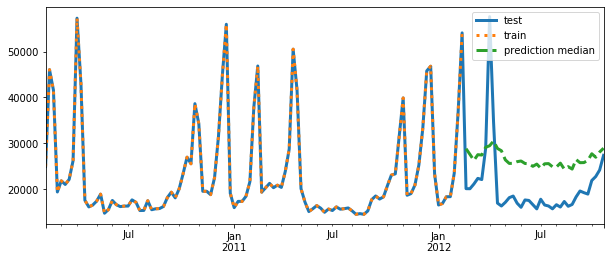

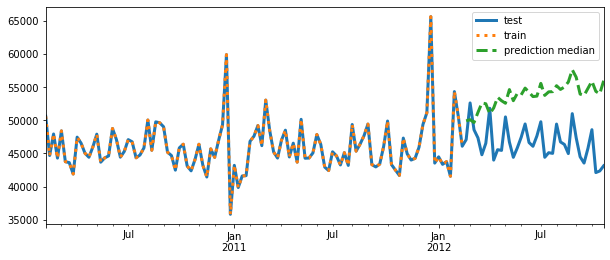

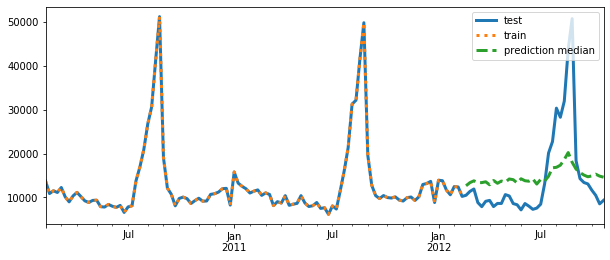

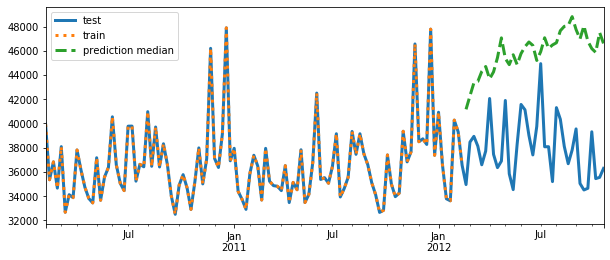

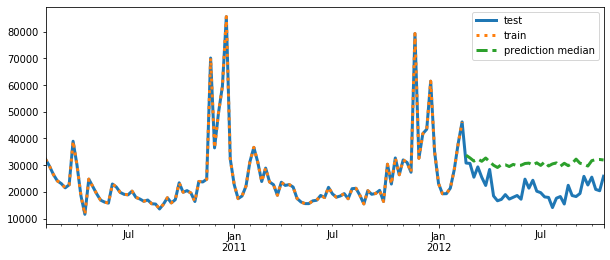

In [30]:
# display train/test time series and prediction median

for time_series_idx in range(0,5):
    plt.figure(figsize=(10,4))
    
    # test data is the whole time series
    time_series[time_series_idx][:-2].plot(label='test', lw=3)
    
    # train data is all but the last prediction pts
    time_series_training[time_series_idx][:-2].plot(label='train', ls=':', lw=3)

    # prediction median is predication for quantile 0.5
    pred = prediction_list[time_series_idx]['0.5']
    # we want our 36 forecasted weeks , 2 last values being store and department number
    pred.index = time_series[time_series_idx][-38:-2].index
    pred.plot(label='prediction median', ls="--", lw=3)
    
    plt.legend()
    plt.show()

In [31]:
# instantiate empty lists to compute WMAE for our series
total_sum_weights=[]
total_sum_weighted_error=[]

for i in range(len(prediction_list)):  
    # merge prediction and train_df to create a dataframe with info to compute WMAE metric 
    prediction_df = pd.DataFrame(prediction_list[i]['0.5'])
    prediction_df.index = time_series[time_series_idx][-38:-2].index
    train_df.index = pd.to_datetime(train_df.index)
    store = time_series[i][-2]
    department = time_series[i][-1]
    data_df = train_df[(train_df.Cat_Store == store)&(train_df.Cat_Dept == department)]
    metric_df = data_df.merge(prediction_df, right_index=True, left_index=True)
    
    # Compute and print WMAE for each series
    metric_df['weighted_error']=metric_df['IsHoliday']*abs(metric_df['Weekly_Sales']-metric_df['0.5'])
    sum_weights = metric_df.IsHoliday.sum()
    sum_weighted_error = metric_df.weighted_error.sum()
    wmae = (1/sum_weights) * sum_weighted_error
    print('Weighted mean absolute error (WMAE) for Cat_Store {} Cat_Dept {} = {}'.format(str(store),str(department),str(wmae)))
    
    if str(wmae) != 'nan':
        total_sum_weights.append(sum_weights)
        total_sum_weighted_error.append(sum_weighted_error)
        
global_wmae = (1/sum(total_sum_weights)) * sum(total_sum_weighted_error)
print('Global Weighted mean absolute error (WMAE) for these predicted series = {}'.format(str(global_wmae)))

Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 0.0 = 7921.791724609376
Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 1.0 = 7485.203445312501
Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 2.0 = 5807.7428046875
Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 3.0 = 7913.309500000002
Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 4.0 = 10011.021333984376
Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 5.0 = 2727.982258789068
Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 6.0 = 7010.793033203125
Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 7.0 = 4111.524828125001
Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 8.0 = 5361.3256035156255
Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 9.0 = 5323.016224609376
Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 10.0 = 5910.453330078126
Weighted mean absolute error (WMAE) for Ca

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in long_scalars
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars


Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 50.0 = 3136.4142189941476
Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 51.0 = 1555.5182548828152
Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 52.0 = 588.0583977356
Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 53.0 = 369.1725900268575
Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 54.0 = 2533.680933105471
Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 55.0 = 1069.5635551757775
Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 56.0 = 19027.553945312506
Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 57.0 = 2214.111595703125
Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 58.0 = nan
Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 59.0 = nan
Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dept 60.0 = 6656.3568359375
Weighted mean absolute error (WMAE) for Cat_Store 0.0 Cat_Dep

In [32]:
def display_quantiles(prediction_list, target_ts=None):
    # show predictions for all input ts
    
    for k in range(5):
        plt.figure(figsize=(12,6))
        # get the target month of data
        if target_ts is not None:
            target = target_ts[k][-prediction_length-2:-2]
            plt.plot(range(len(target)), target, label='target')
        # get the quantile values at 10 and 90%
        p10 = prediction_list[k]['0.1']
        p90 = prediction_list[k]['0.9']
        # fill the 80% confidence interval
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        
        # plot the median prediction line
        p50 = prediction_list[k]['0.5']
        plt.plot(p10.index, p50 , label='prediction median')
        
        plt.legend()
        plt.show()

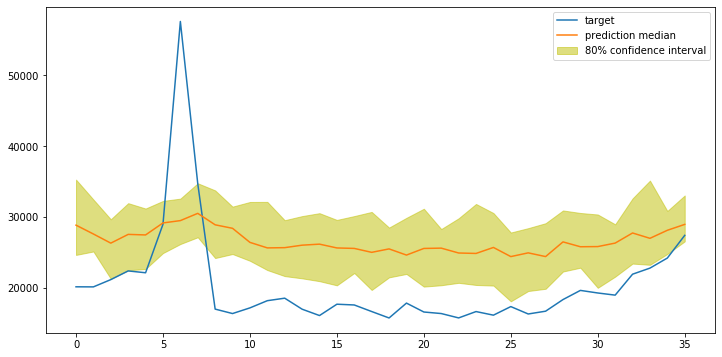

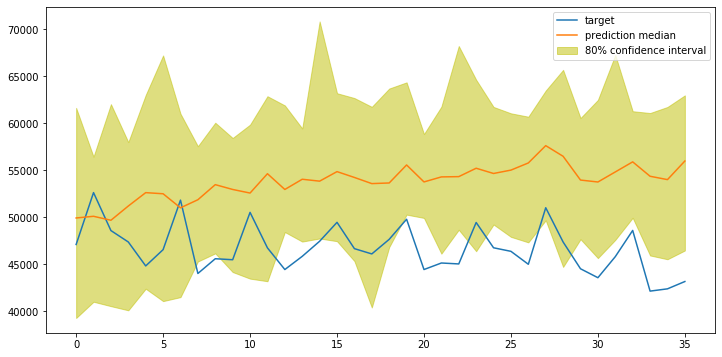

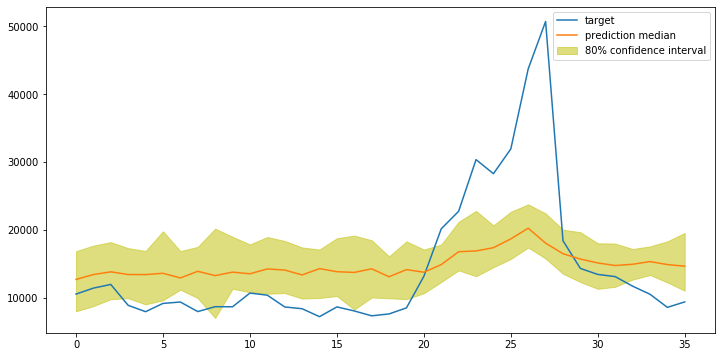

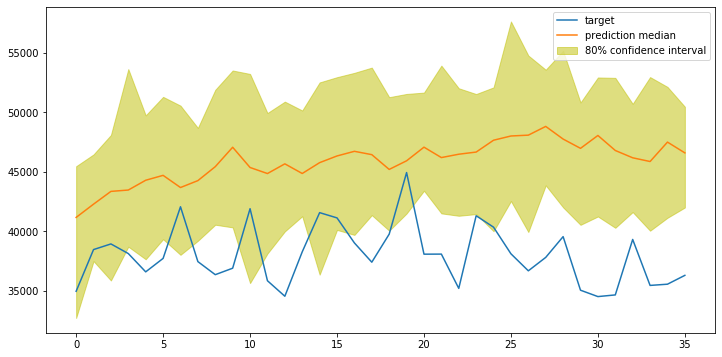

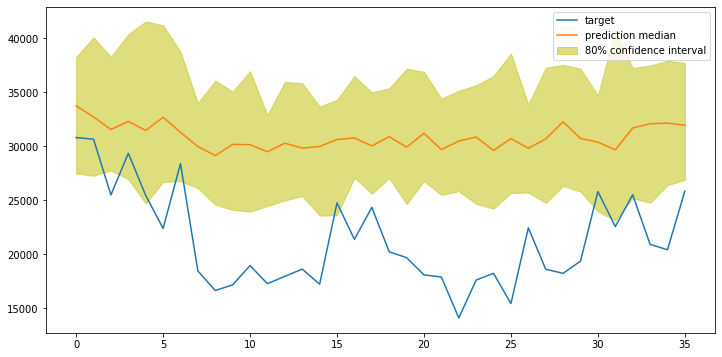

In [35]:
# display predictions
display_quantiles(prediction_list, target_ts)

In [56]:
# delete the endpoint
predictor.delete_endpoint()